In [1]:
# Import modules

from music21 import corpus, instrument, converter
import pickle
import networkx as nx
import matplotlib.pyplot as plt

from dimod import to_networkx_graph
from dwave.samplers import SteepestDescentSolver, SimulatedAnnealingSampler, RandomSampler
from dwave.system import DWaveSampler, EmbeddingComposite, LazyFixedEmbeddingComposite, FixedEmbeddingComposite
import dwave_networkx as dnx

from boundaryDetection import extractPhrases
from plotters import plotHistogram, plotBoundaryStrength, plotSample, plotArrangement
from qubo import createBQM

In [2]:
identifier = "haydn_opus1no1_movement1_reduced"
instruments = {"red":instrument.Flute, "green":instrument.Oboe, "blue":instrument.Bassoon}

excerpt = converter.parse(f"../Pickles/{identifier}.musicxml")
phrases = pickle.load(open(f"../Pickles/{identifier}_phrases.pkl", "rb"))
G = pickle.load(open(f"../Pickles/{identifier}_graph.pkl", "rb"))
bqm = pickle.load(open(f"../Pickles/{identifier}_bqm.pkl", "rb"))
embedding = pickle.load(open(f"../Pickles/{identifier}_embedding.pkl", "rb"))

In [ ]:
# https://www.music21.org/music21docs/about/referenceCorpus.html#referencecorpus

beethoven = "beethoven/opus74.mxl"

score = corpus.parse("haydn/opus1no1/movement1.mxl").measures(0, 24)
score.write(fmt="musicxml", fp=f"../Pickles/{identifier}")
score.show()

In [ ]:
# Extract phrases from score

phrases = extractPhrases(score, 0.3, (0.3, 0.6))

for part in score.parts:
    plotBoundaryStrength(part, 0.3)

In [ ]:
# Load created graph

G = pickle.load(open(f"../Pickles/{identifier}_graph.pkl", "rb"))
pos = nx.spring_layout(G, k=0.5, seed=8)
nx.draw(G, pos=pos, node_size=15, width=0.2)

In [ ]:
# Create colouring problem BQM

createBQM(G, phrases, instruments)

#pickle.dump(bqm, open(f"../Pickles/{identifier}_bqm.pkl", "wb"))

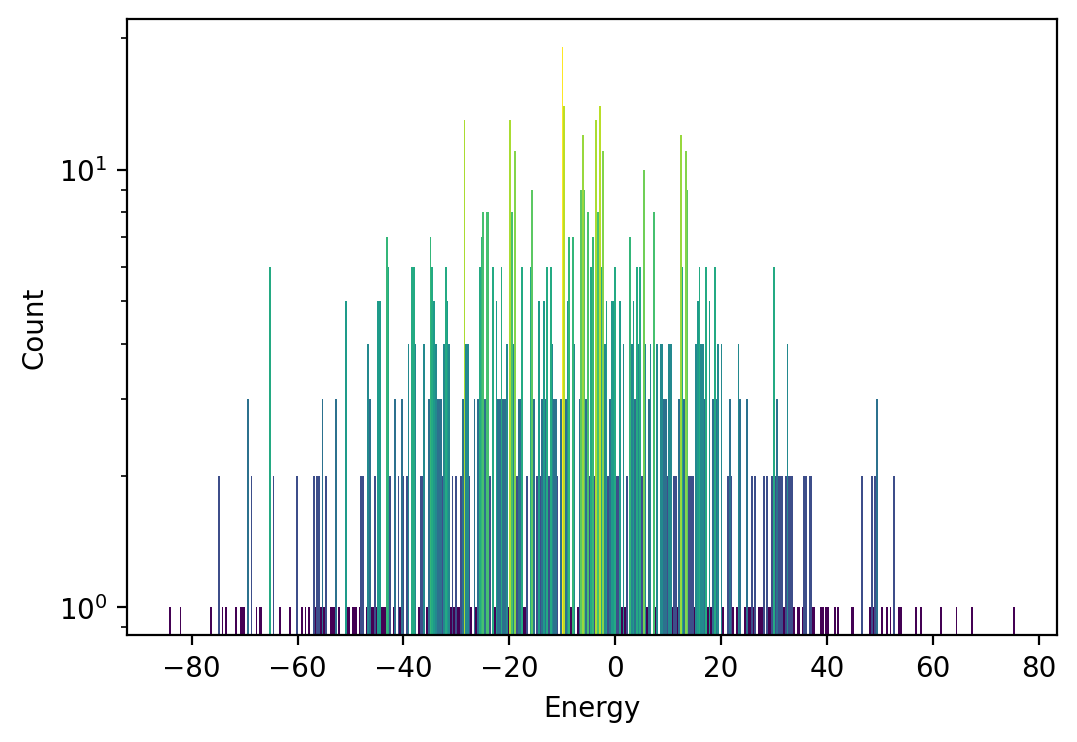

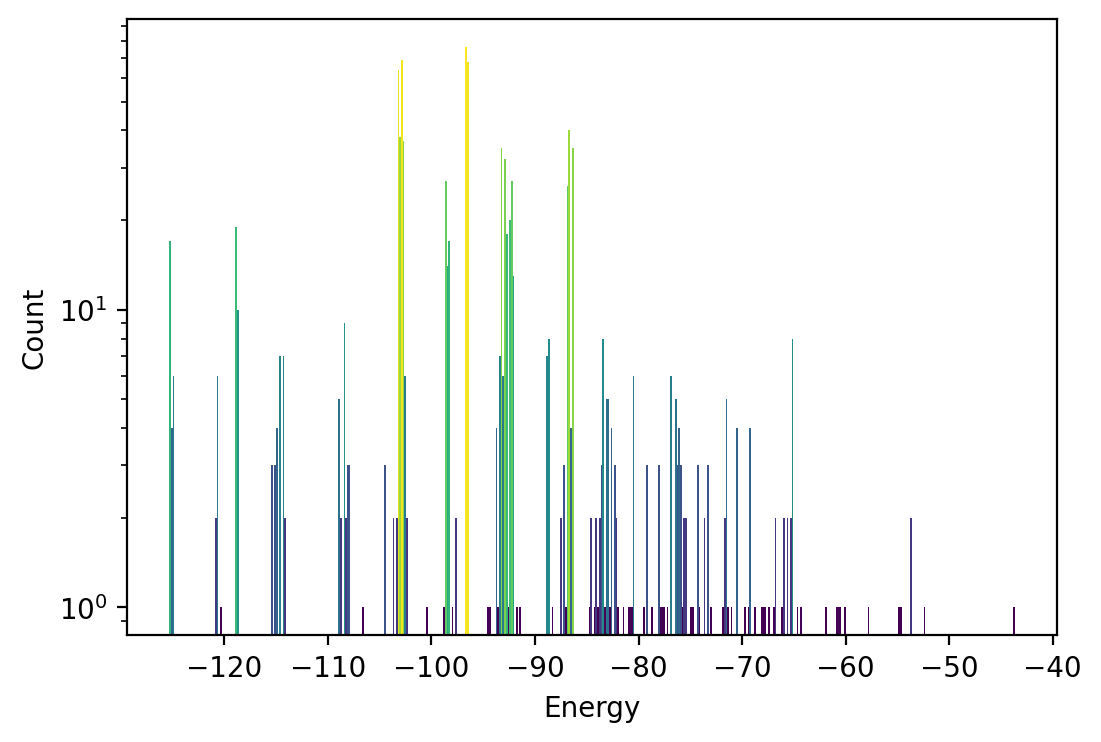

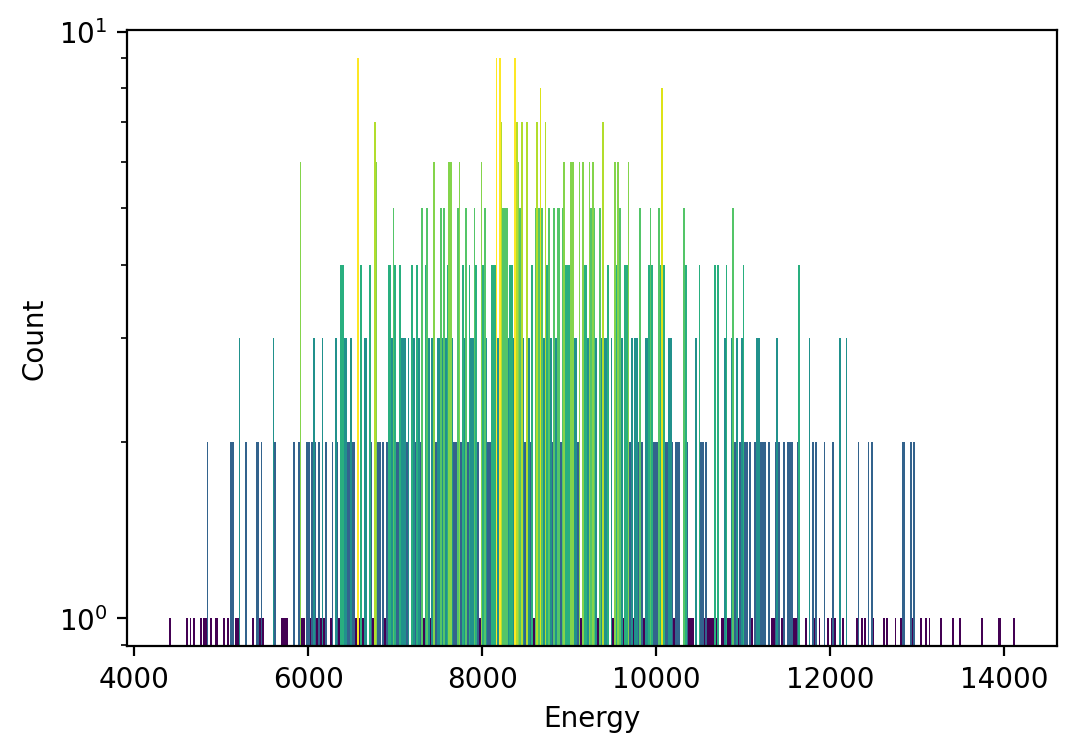

In [3]:
# Solve classically
sd = SteepestDescentSolver().sample(bqm, num_reads=1000).to_pandas_dataframe(True)
sa = SimulatedAnnealingSampler().sample(bqm, num_reads=1000).to_pandas_dataframe(True)
random = RandomSampler().sample(bqm, num_reads=1000).to_pandas_dataframe(True)

# Compare energies from different methods
plotHistogram(sd)
plotHistogram(sa)
plotHistogram(random)
# Just because it doesn't crash doesn't mean it passed

In [ ]:
P = dnx.pegasus_graph(8)
B = to_networkx_graph(bqm)

embedding = pickle.load(open(f"../Pickles/{identifier}_embedding.pkl", "rb"))
dnx.draw_pegasus_embedding(P, embedding, B, node_size=10)

In [5]:
sampler = FixedEmbeddingComposite(DWaveSampler(), embedding)
reads = 100
anneal_time = 200
chain_strength = 100
results = sampler.sample(bqm, num_reads=reads, annealing_time=anneal_time, chain_strength=chain_strength, label=f"Haydn_{reads}r_{anneal_time}us").to_pandas_dataframe(True)

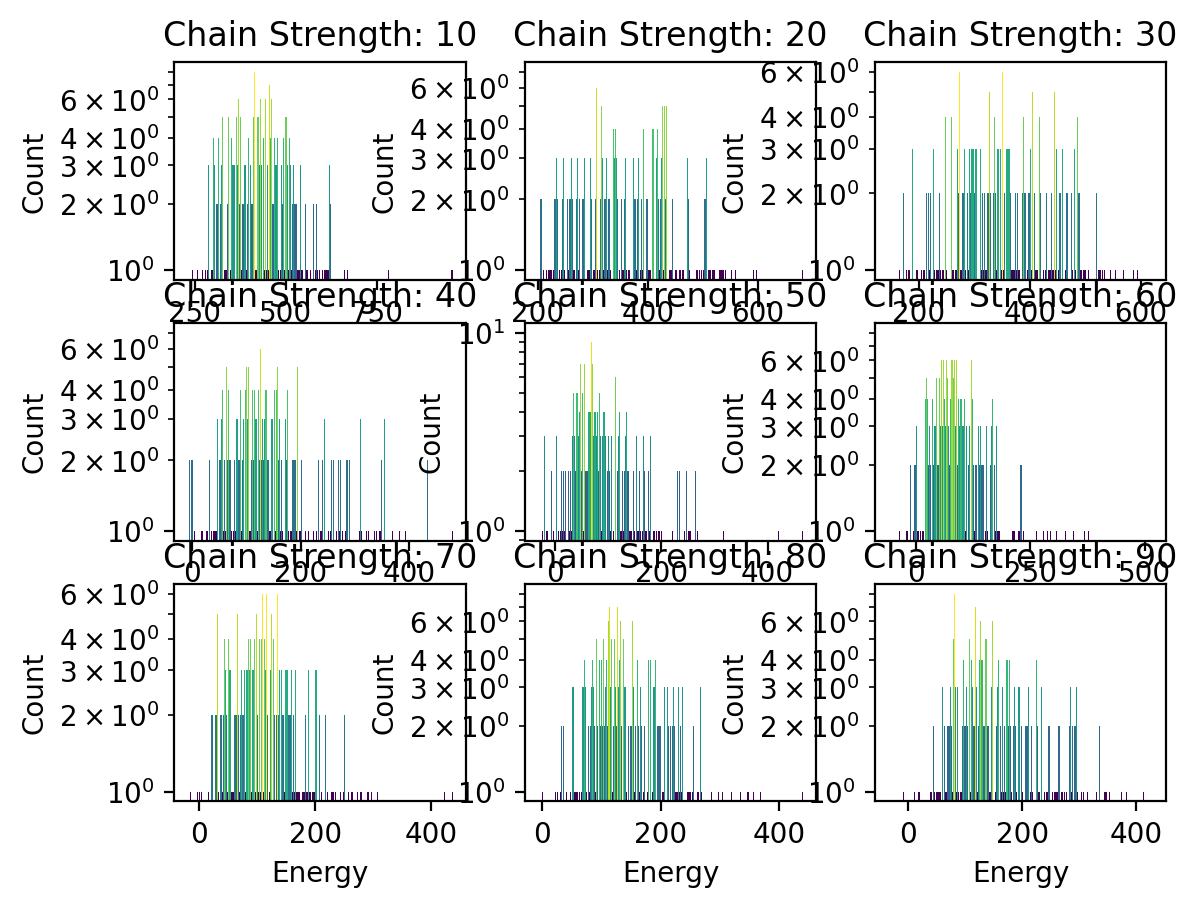

In [ ]:
chain_strengths = [10, 20, 30, 40, 50, 60, 70, 80, 90]
sampler = FixedEmbeddingComposite(DWaveSampler(), embedding)
reads = 500
anneal_time = 400

for cs in chain_strengths:
    sampleset = sampler.sample(bqm, num_reads=reads, annealing_time=300, chain_strength=cs, label=f"Haydn_{reads}r_{anneal_time}us").to_pandas_dataframe(True)
    plt.subplot(3, 3, chain_strengths.index(cs)+1, sharex=True, sharey=True)
    plt.title(f"Chain Strength: {cs}")
    plotHistogram(sampleset)

plt.show()

In [ ]:
pickle.dump(dict(sampler.properties["embedding"]), open(f"../Pickles/{identifier}_embedding.pkl", "wb"))

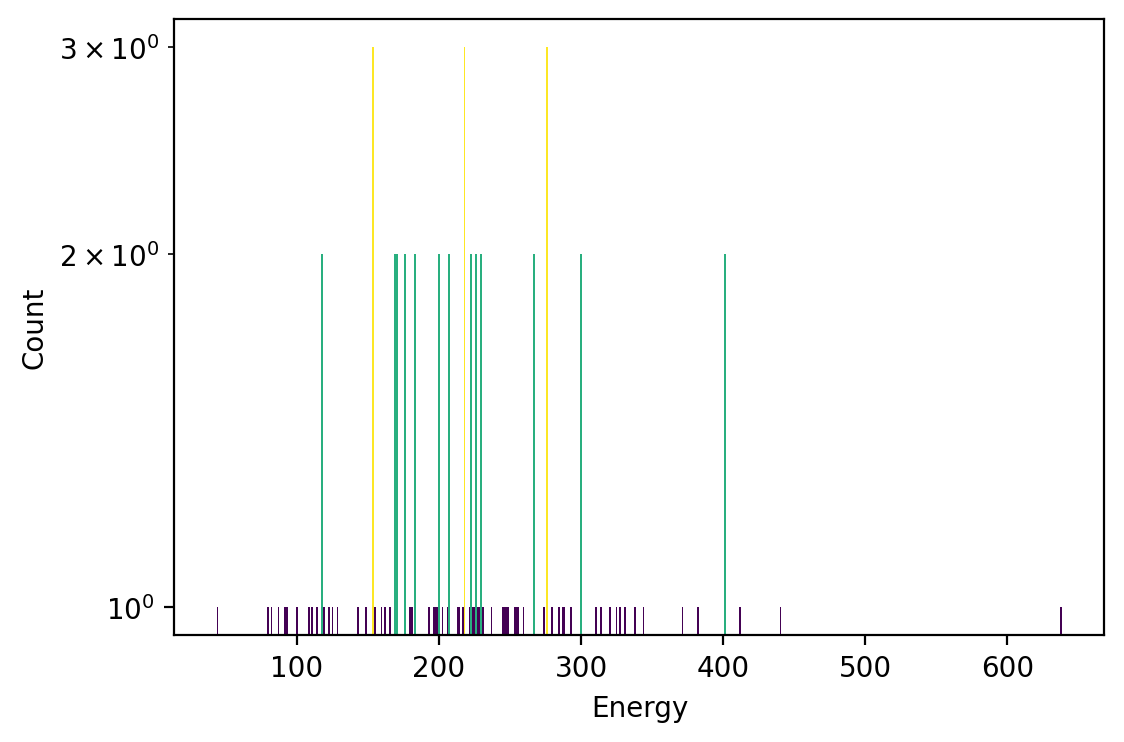

                                              sample     energy  \
0  {'Cello_10_blue': 1, 'Cello_10_green': 0, 'Cel...  43.706728   
1  {'Cello_10_blue': 0, 'Cello_10_green': 1, 'Cel...  79.845847   
2  {'Cello_10_blue': 1, 'Cello_10_green': 0, 'Cel...  82.701972   
3  {'Cello_10_blue': 0, 'Cello_10_green': 1, 'Cel...  86.957554   
4  {'Cello_10_blue': 1, 'Cello_10_green': 0, 'Cel...  91.412784   

   num_occurrences  chain_break_fraction  
0                1                   0.0  
1                1                   0.0  
2                1                   0.0  
3                1                   0.0  
4                1                   0.0  


<Figure size 640x480 with 0 Axes>

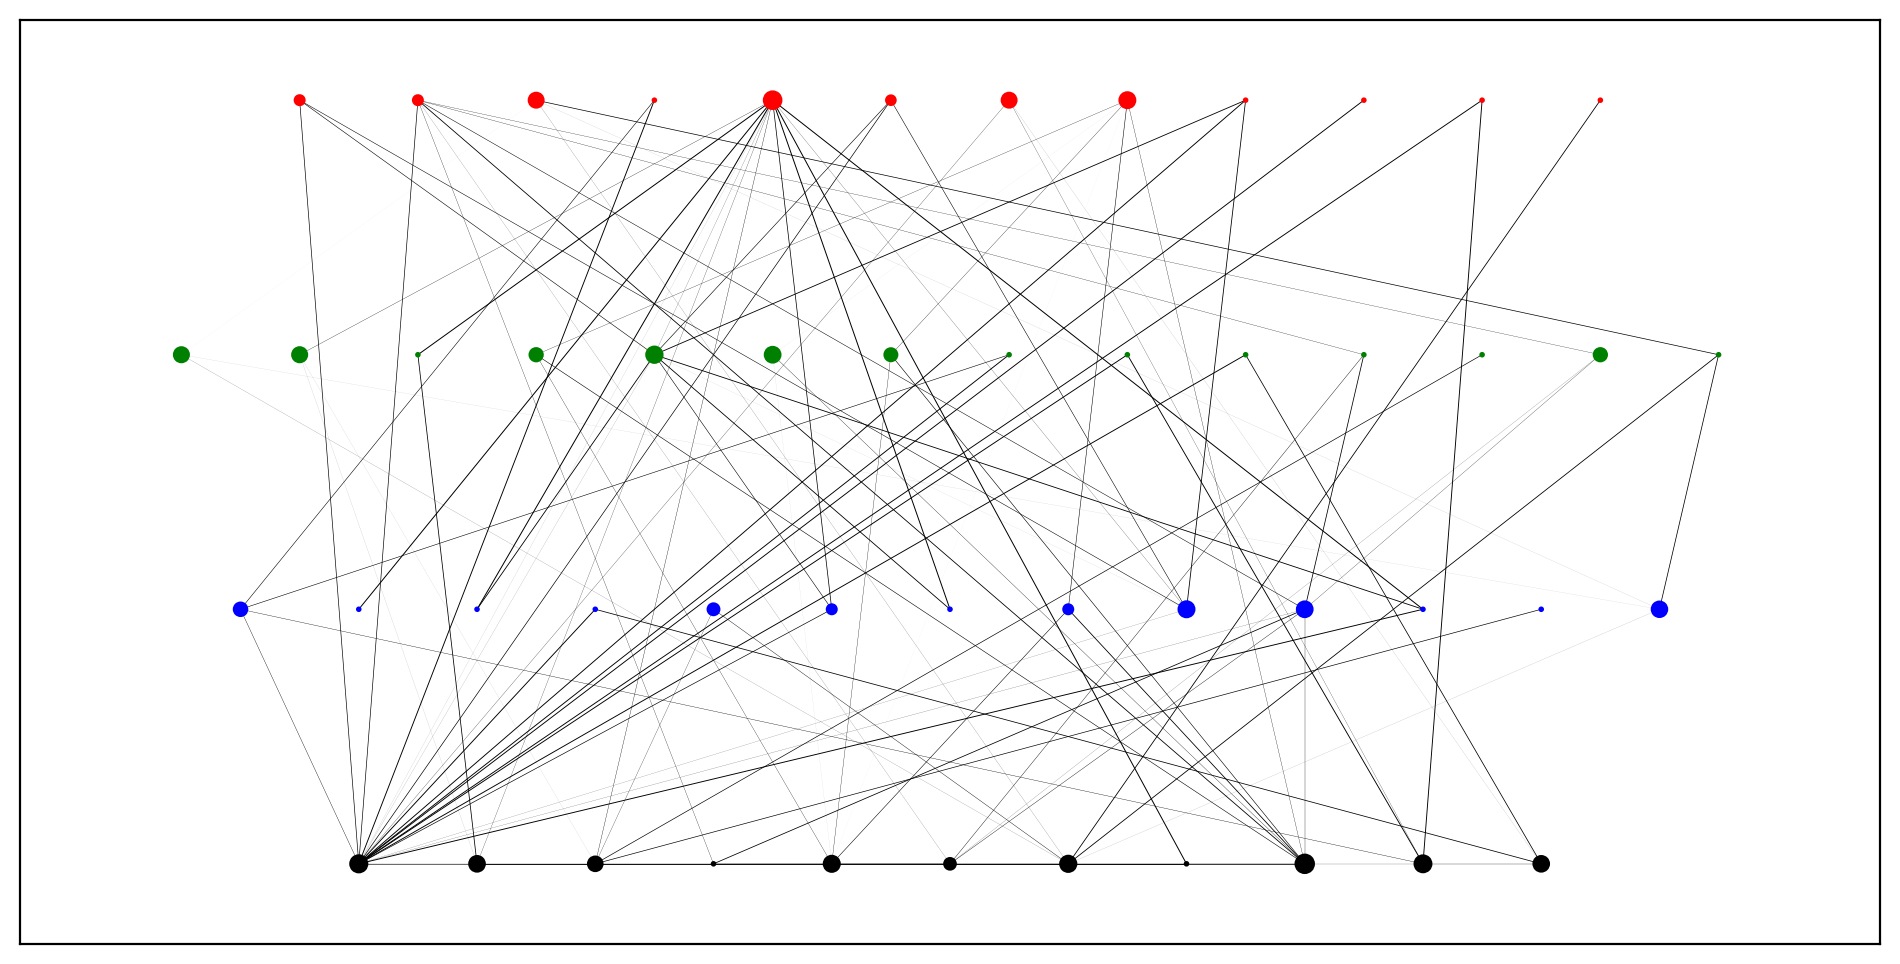

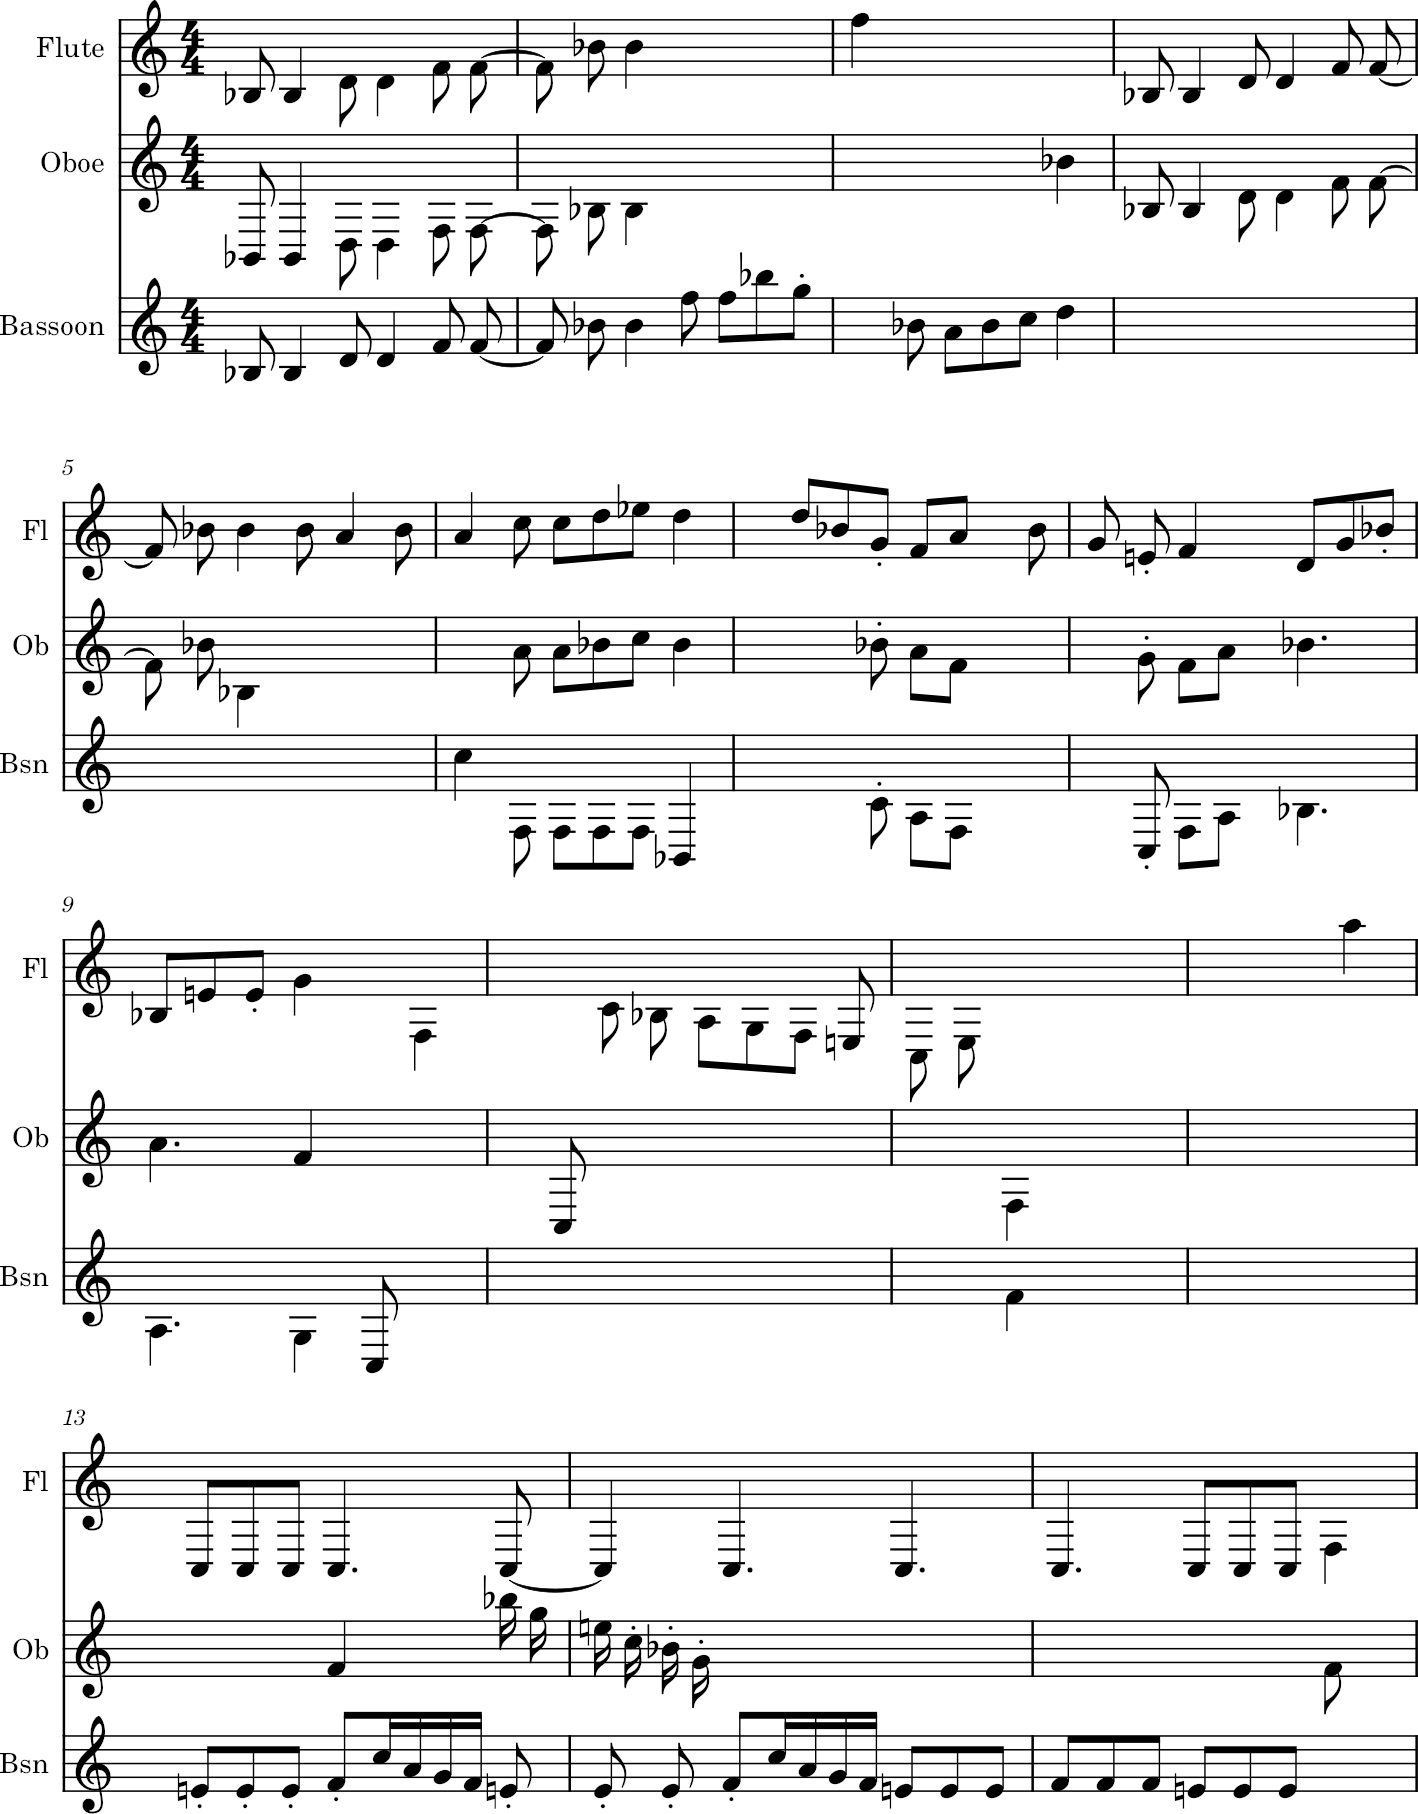

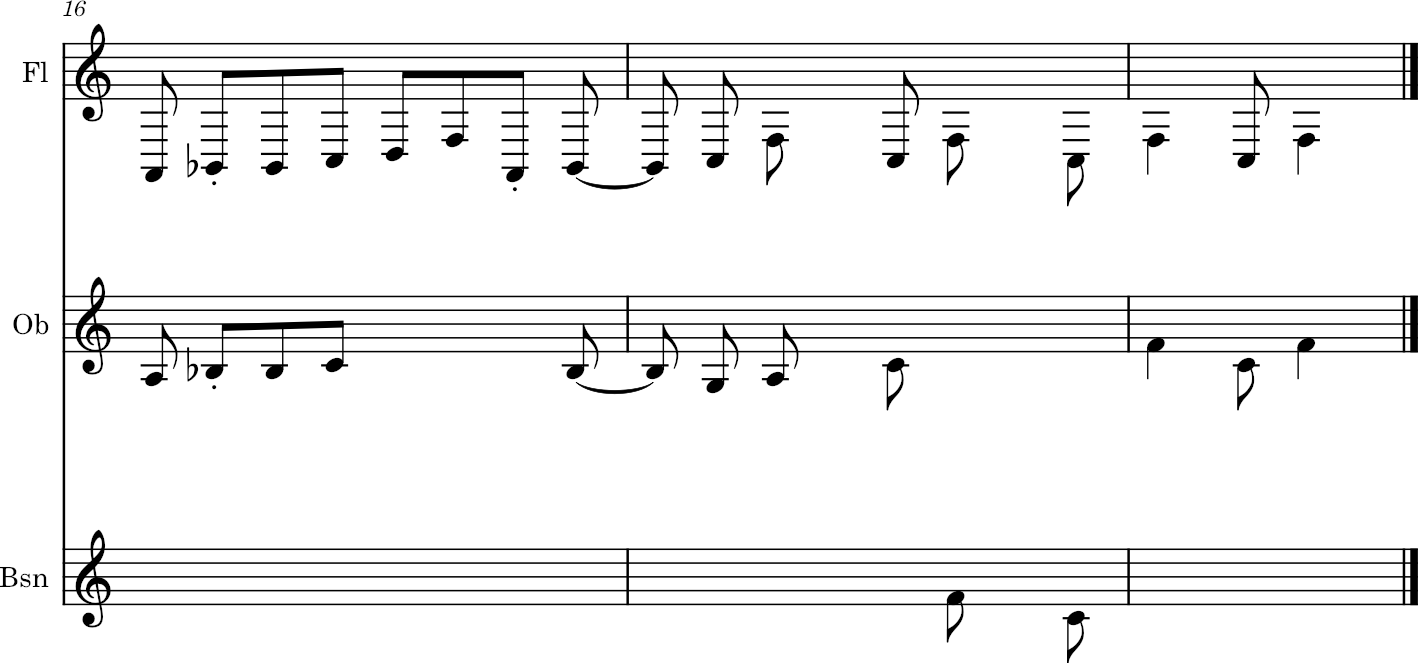

In [6]:
# Show results

plotHistogram(results)

sorted = results.sort_values("energy")
print(sorted.head())

S = sampler.to_networkx_graph()
Spos = nx.spring_layout(S, k=0.5, seed=8)
#nx.draw(S, Spos, node_size=15, width=.2)

sample = sorted["sample"][0]
plotSample(results.sort_values("energy")["sample"][0], G, [phrase for part in phrases for phrase in part])
plotArrangement(sample, phrases, instruments)

In [ ]:

#arrangement.write(fmt="musicxml.pdf", fp="../Figures/poly.pdf", dpi=300)

# TODO: Allow specification of instrument for each part
# TODO: Bias selection of phrases to specific parts (e.g. by checking ambitus)
# TODO: Add meaningful edge weightings
# TODO: Find interesting constraints to add to BQM
# TODO: Are there more efficient ways to add constraints?